In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join as pjoin
import sys
import time
import itertools
from tqdm import tqdm
import pickle
import json
import collections

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns
%matplotlib inline

In [3]:
sys.path.insert(0, '/Users/antonandreitsev/Desktop/lenta/')

In [4]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [5]:
PROJECT_PATH = '/Users/antonandreitsev/Desktop/lenta/'

---

### Loading data

In [6]:
df = pd.read_csv(pjoin(PROJECT_PATH, 'data/raw', 'hist_data.csv'))
print(f"df: {df.shape[0]:,} x {df.shape[1]:,}")
df.head(3)

df: 4,529,889 x 8


,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods,weight
0,95203091,98506637863,2021-07-01 00:03:44,202808329,1.000,79.990,False,11.14
1,95203091,98506637863,2021-07-01 00:03:44,202953905,1.072,44.945,True,11.14
2,95203091,98506637863,2021-07-01 00:03:44,203566452,1.000,69.990,False,11.14


### EDA

In [7]:
print(f"number of unique buyers: {df['buyer_id'].nunique():,}")
print(f"number of unique items: {df['item_id'].nunique():,}")
print(f"number of unique orders: {df['pav_order_id'].nunique():,}")

number of unique buyers: 63,925
number of unique items: 52,472
number of unique orders: 231,339


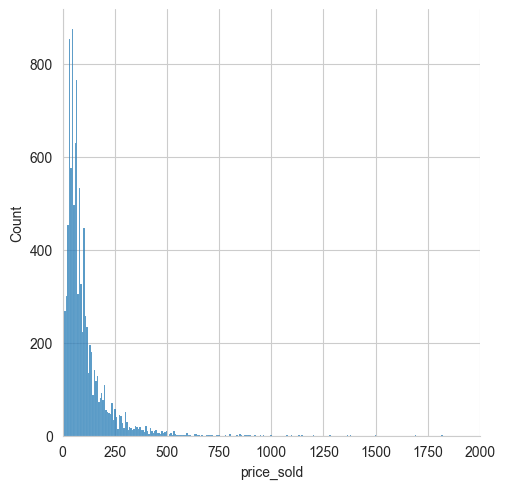

In [9]:
np.random.seed(123412)
tmp_df = df.sample(n=10_000)
sns.displot(tmp_df['price_sold'])
plt.xlim(0, 2000);

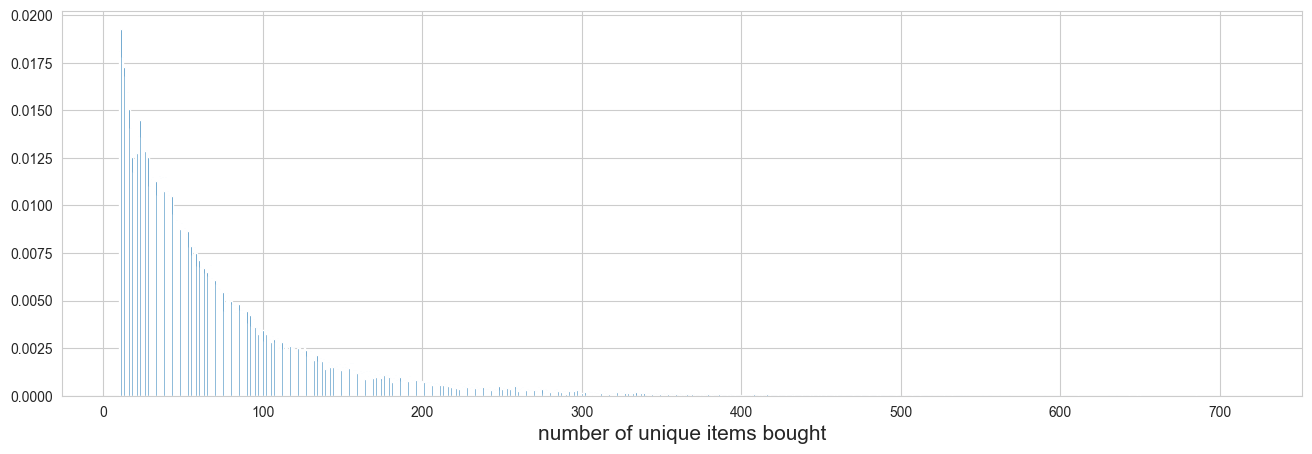

In [26]:
tmp_df = (
    df
    .groupby(['buyer_id'])
    .agg(
        n_unq_items = pd.NamedAgg(column='item_id', aggfunc=lambda x: len(set(x)))
    )
    .reset_index()
    .groupby(['n_unq_items'])
    .agg(
        cnt = pd.NamedAgg(column='buyer_id', aggfunc=lambda x: len(x))
    )
    .reset_index()
    .sort_values(by=['n_unq_items'], ascending=True)
)
plt.figure(figsize=(16, 5))
plt.bar(tmp_df['n_unq_items'], tmp_df['cnt'] / tmp_df['cnt'].sum());
plt.xlabel('number of unique items bought', fontsize=15);

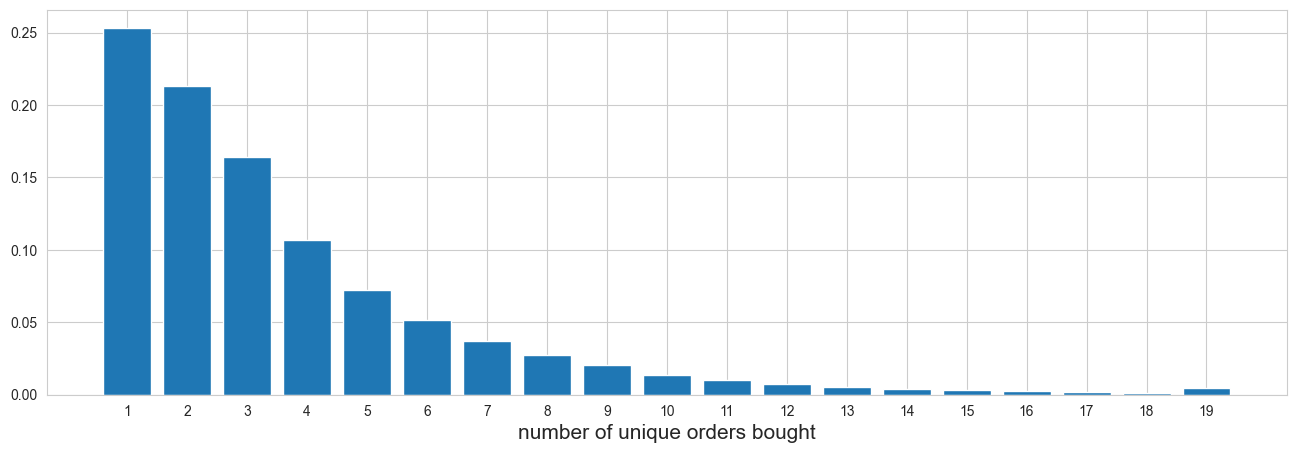

In [28]:
tmp_df = (
    df
    .groupby(['buyer_id'])
    .agg(
        n_unq_orders = pd.NamedAgg(column='pav_order_id', aggfunc=lambda x: len(set(x)))
    )
    .reset_index()
    .groupby(['n_unq_orders'])
    .agg(
        cnt = pd.NamedAgg(column='buyer_id', aggfunc=lambda x: len(x))
    )
    .reset_index()
    .sort_values(by=['n_unq_orders'], ascending=True)
)
plt.figure(figsize=(16, 5))
plt.bar(tmp_df['n_unq_orders'], tmp_df['cnt'] / tmp_df['cnt'].sum());
plt.xlabel('number of unique orders bought', fontsize=15);
plt.xticks(tmp_df['n_unq_orders']);

In [ ]:
# 1) Профит с одного покупателя 
# 2) Распределение ценовых категорий среди покупок

In [36]:
df.loc[
    # (df['item_id'] == 203370019)
    (df['item_id'] == 203446974)
]

,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods,weight
146,94616383,98506638994,2021-07-01 00:23:03,203446974,1.0,10.99,False,10.35
474,95836540,98506640780,2021-07-01 01:12:28,203446974,5.0,10.99,False,8.46
1016,95112975,98506644353,2021-07-01 04:14:14,203446974,15.0,10.99,False,42.43
2619,95699814,98506649417,2021-07-01 06:29:26,203446974,2.0,10.99,False,8.50
2696,94888799,98506649606,2021-07-01 06:32:43,203446974,1.0,10.99,False,17.15
...,...,...,...,...,...,...,...,...
4490139,95169398,98520013371,2021-09-03 08:03:28,203446974,4.0,13.23,False,31.83
4490244,95169398,98520014608,2021-09-03 08:09:22,203446974,5.0,14.99,False,47.45
4506345,95993034,98520203537,2021-09-03 18:28:48,203446974,5.0,14.99,False,8.24
4509756,95456488,98520294906,2021-09-04 08:50:00,203446974,5.0,14.57,False,49.92


In [35]:
(
    df.loc[
        (df['flag_weight_goods'] == False)
    ]
    .groupby(['item_id'])
    .agg(
        n_unq_cnts = pd.NamedAgg(column='count', aggfunc=lambda x: len(set(x)))
    )
    .sort_values(by=['n_unq_cnts'], ascending=False)
)

,n_unq_cnts
item_id,
203446974,31
203440878,28
203833320,28
203087864,25
203833280,25
...,...
204007625,1
204007615,1
204007614,1


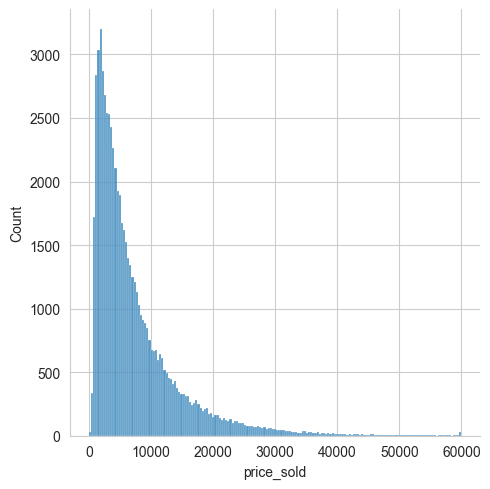

In [42]:
tmp_df = (
    df
    .groupby(['buyer_id'])
    ['price_sold']
    .sum()
    .reset_index()
)
sns.displot(tmp_df['price_sold'].clip(upper=60_000));

### Data splitting

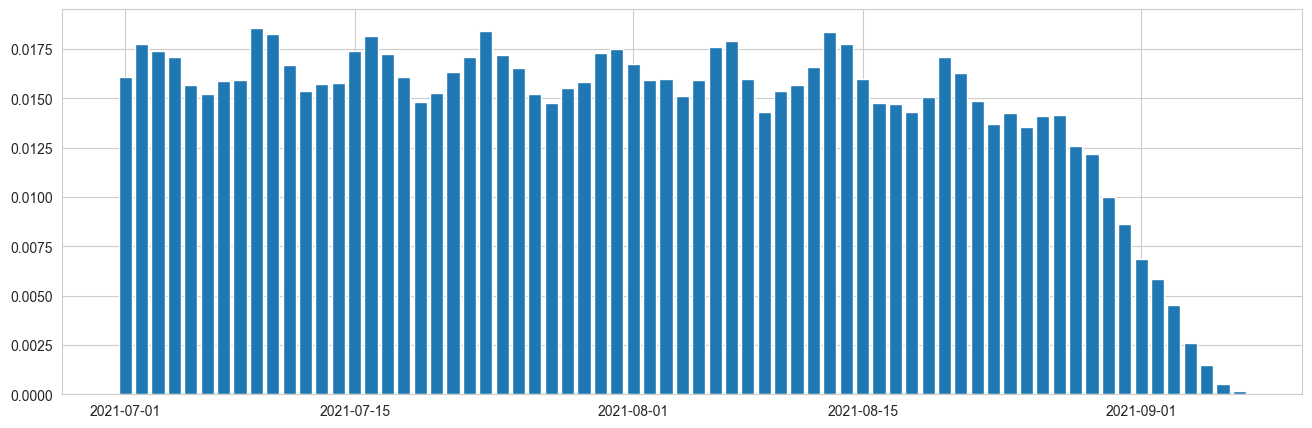

In [50]:
tmp_series = pd.to_datetime(df['created']).dt.date
tmp = tmp_series.value_counts(1).sort_index().reset_index()
plt.figure(figsize=(16, 5))
plt.bar(tmp['created'], tmp['proportion']);

In [58]:
train_condition = pd.to_datetime(df['created']) <= pd.Timestamp('2021-08-20')
train_df = df.loc[(train_condition)].reset_index(drop=True)
test_df = df.loc[np.logical_not(train_condition)].reset_index(drop=True)
assert train_df.shape[0] + test_df.shape[0] == df.shape[0]
print(f'train_df: {train_df.shape[0]:,} x {train_df.shape[1]:,}')
print(f'test_df: {test_df.shape[0]:,} x {test_df.shape[1]:,}')

train_df: 3,698,467 x 8
test_df: 831,422 x 8


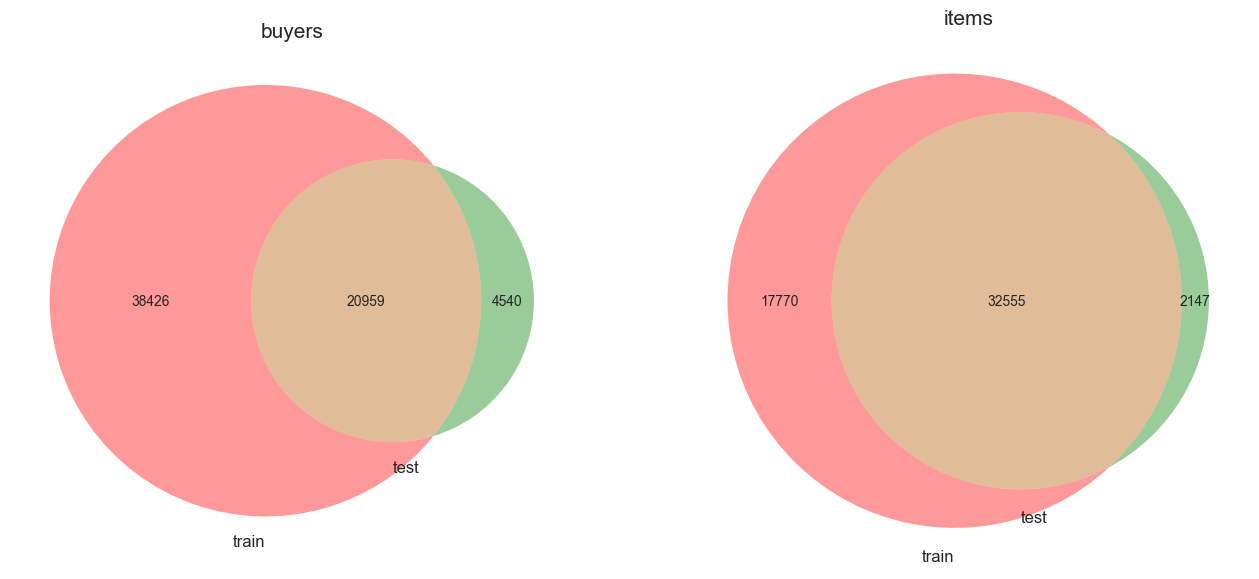

In [61]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 7))
ax[0].set_title('buyers', fontsize=15)
venn2(
    subsets=[
        set(train_df['buyer_id']),
        set(test_df['buyer_id']),
    ],
    set_labels=['train', 'test'],
    ax=ax[0]
);
ax[1].set_title('items', fontsize=15)
venn2(
    subsets=[
        set(train_df['item_id']),
        set(test_df['item_id']),
    ],
    set_labels=['train', 'test'],
    ax=ax[1]
);

In [82]:
import numpy as np
from typing import List

def _compute_binary_relevance(
    recommended_items_list: List[int],
    true_items_list: List[int],
) -> List[int]:
  res = []
  true_items_set = set(true_items_list)
  for item in recommended_items_list:
    res.append(
        1 if item in true_items_set else 0
    )
  return res


def ap_at_k(
    recommended_items_list: List[int],
    true_items_list: List[int],
    k: int
) -> float:
  binary_rel = _compute_binary_relevance(
      recommended_items_list=recommended_items_list,
      true_items_list=true_items_list
  )
  binary_rel = binary_rel[:k]
  mean_cumrel = np.cumsum(binary_rel) / k
  result = (
      (1 / min(k, len(true_items_list))) * (np.array(binary_rel) @ mean_cumrel)
  )
  return result


def map_at_k(
    recommended_items_lists: List[List[int]],
    true_items_lists: List[List[int]],
    k: int
) -> float:
  """
  Computes ap@k for all buyers
  """
  assert len(recommended_items_lists) == len(true_items_lists), \
  'len(true_items_list) != len(recommended_items_list)'

  res = []
  for true_lst, rec_lst in tqdm(zip(true_items_lists, recommended_items_lists)):
    res.append(
        ap_at_k(
            recommended_items_list=rec_lst,
            true_items_list=true_lst,
            k=k
        )
    )
  return np.mean(res)

In [67]:
map_at_k(
    recommended_items_lists=[[1, 2, 5]],
    true_items_lists=[[1, 2, 3]],
    k=3
)

0.3333333333333333

In [71]:
top_popular_items = (
    train_df
    .groupby(['item_id'])
    ['buyer_id']
    .count()
    .sort_values(ascending=False)
    .index
    .values
)
top_popular_items

array([202820148, 202872237, 202809628, ..., 203532473, 203532462,
       218108195])

In [74]:
true_bought_test_df = (
    test_df
    .groupby(['buyer_id'])
    ['item_id']
    .agg(list)
    .reset_index()
)
true_bought_test_df

,buyer_id,item_id
0,94578658,"[202884490, 203528997, 202807362, 203367251, 2..."
1,94579463,"[203410388, 203525574, 203432720, 204011845, 2..."
2,94579825,"[202807002, 203578026, 203439672, 204084512, 2..."
3,94579858,"[202806956, 204415211, 202838209, 202807087, 2..."
4,94580007,"[202834549, 202803554, 202795684, 205755780, 2..."
...,...,...
25494,96395136,"[202822801, 205757948, 202818687, 203576721, 2..."
25495,96397556,"[202806882, 203529344, 203404725, 205101241, 2..."
25496,96399270,"[203172333, 202824511, 204070431, 212519969, 2..."
25497,96399769,"[203420164, 203469410, 202963771, 203410558, 2..."


In [77]:
predict_bought_test_df = true_bought_test_df[['buyer_id']]
predict_bought_test_df['predictions'] = None
predict_bought_test_df['predictions'].loc[0] = top_popular_items[:10]
predict_bought_test_df['predictions'].fillna(method='ffill', inplace=True)
predict_bought_test_df

/var/folders/63/6fv4k0s10bg7z3ptjmyd53c80000gn/T/ipykernel_27047/310906723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_bought_test_df['predictions'].loc[0] = top_popular_items[:10]


,buyer_id,predictions
0,94578658,"[202820148, 202872237, 202809628, 202838754, 2..."
1,94579463,"[202820148, 202872237, 202809628, 202838754, 2..."
2,94579825,"[202820148, 202872237, 202809628, 202838754, 2..."
3,94579858,"[202820148, 202872237, 202809628, 202838754, 2..."
4,94580007,"[202820148, 202872237, 202809628, 202838754, 2..."
...,...,...
25494,96395136,"[202820148, 202872237, 202809628, 202838754, 2..."
25495,96397556,"[202820148, 202872237, 202809628, 202838754, 2..."
25496,96399270,"[202820148, 202872237, 202809628, 202838754, 2..."
25497,96399769,"[202820148, 202872237, 202809628, 202838754, 2..."


In [78]:
merged_df = (
    true_bought_test_df
    .merge(
        predict_bought_test_df,
        on=['buyer_id'],
        how='inner'
    )
)
merged_df

,buyer_id,item_id,predictions
0,94578658,"[202884490, 203528997, 202807362, 203367251, 2...","[202820148, 202872237, 202809628, 202838754, 2..."
1,94579463,"[203410388, 203525574, 203432720, 204011845, 2...","[202820148, 202872237, 202809628, 202838754, 2..."
2,94579825,"[202807002, 203578026, 203439672, 204084512, 2...","[202820148, 202872237, 202809628, 202838754, 2..."
3,94579858,"[202806956, 204415211, 202838209, 202807087, 2...","[202820148, 202872237, 202809628, 202838754, 2..."
4,94580007,"[202834549, 202803554, 202795684, 205755780, 2...","[202820148, 202872237, 202809628, 202838754, 2..."
...,...,...,...
25494,96395136,"[202822801, 205757948, 202818687, 203576721, 2...","[202820148, 202872237, 202809628, 202838754, 2..."
25495,96397556,"[202806882, 203529344, 203404725, 205101241, 2...","[202820148, 202872237, 202809628, 202838754, 2..."
25496,96399270,"[203172333, 202824511, 204070431, 212519969, 2...","[202820148, 202872237, 202809628, 202838754, 2..."
25497,96399769,"[203420164, 203469410, 202963771, 203410558, 2...","[202820148, 202872237, 202809628, 202838754, 2..."


In [81]:
[list(preds) for preds in merged_df['predictions'].values]

[[202820148,
  202872237,
  202809628,
  202838754,
  202862432,
  203059303,
  202791192,
  203068900,
  202864758,
  202854572],
 [202820148,
  202872237,
  202809628,
  202838754,
  202862432,
  203059303,
  202791192,
  203068900,
  202864758,
  202854572],
 [202820148,
  202872237,
  202809628,
  202838754,
  202862432,
  203059303,
  202791192,
  203068900,
  202864758,
  202854572],
 [202820148,
  202872237,
  202809628,
  202838754,
  202862432,
  203059303,
  202791192,
  203068900,
  202864758,
  202854572],
 [202820148,
  202872237,
  202809628,
  202838754,
  202862432,
  203059303,
  202791192,
  203068900,
  202864758,
  202854572],
 [202820148,
  202872237,
  202809628,
  202838754,
  202862432,
  203059303,
  202791192,
  203068900,
  202864758,
  202854572],
 [202820148,
  202872237,
  202809628,
  202838754,
  202862432,
  203059303,
  202791192,
  203068900,
  202864758,
  202854572],
 [202820148,
  202872237,
  202809628,
  202838754,
  202862432,
  203059303,
  202

In [85]:
np.random.choice(list(set(train_df['item_id'])), size=10)

array([203429931, 205757676, 203580459, 202795710, 205785123, 204089402,
       203444399, 202808652, 204098578, 211054969])

In [88]:
unq_items_list = list(set(train_df['item_id']))
print(len(unq_items_list))

50325


In [89]:
random_predictions = [list(np.random.choice(unq_items_list, size=10)) for i in tqdm(range(len(merged_df)))]


  0%|          | 0/25499 [00:00<?, ?it/s]

100%|██████████| 25499/25499 [00:30<00:00, 823.88it/s]


In [90]:
metric = map_at_k(
    recommended_items_lists=random_predictions,
    true_items_lists=[list(preds) for preds in merged_df['item_id'].values],
    k=10
)
metric

25499it [00:00, 111977.21it/s]


5.451194164477039e-05

In [83]:
metric = map_at_k(
    recommended_items_lists=[list(preds) for preds in merged_df['predictions'].values],
    true_items_lists=[list(preds) for preds in merged_df['item_id'].values],
    k=10
)
metric

25499it [00:00, 104919.53it/s]


0.023069139966273196